## Imports and functions

### "R magic" extension

In [1]:
%load_ext rpy2.ipython

### Python imports and functions

In [2]:
from mathutils.geometry import intersect_point_line
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
import numpy as np
from soft_knn import SoftKNN, softmax
import cvxpy as cp
from tqdm import tqdm 
from itertools import combinations
import warnings
import pandas as pd
import poisson_disc as poi
warnings.filterwarnings("ignore")
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def get_projections(centroids, endpoints=[0,-1]):
    intersects = [list(intersect_point_line(centroid, centroids[endpoints[0]], centroids[endpoints[1]])[0]) for centroid in centroids]
    return np.array(intersects)
def dist(a,b):
    return np.linalg.norm(a-b)
def get_dists(intersects, active_classes):
    inter = intersects[active_classes]
    dists = [dist(inter[0],inter[i]) for i in range(len(inter))]
    return dists
def mid(a,b):
    return (a+b)/2
def get_mids(intersects, active_classes):
    inter = intersects[active_classes]
    mids = [mid(inter[i],inter[i+1]) for i in range(len(inter)-1)]
    return mids
def get_mid_dists(intersects, active_classes):
    inter = intersects[active_classes]
    mids = [mid(inter[i],inter[i+1]) for i in range(len(inter)-1)]
    mid_dists = [dist(inter[0],mids[i]) for i in range(len(mids))] 
    return mid_dists
def create_system_V4(n, mid_dists=None, tot_dist= None, endpoints=None, dists=None, var=None):
    A=[]
    assert(len(mid_dists)==n-1)
    constraints=[]
    for i in range(len(dists)):
        
        vector = np.zeros(n*2)
        vector[i] += 1./(dists[i]+0.01-endpoints[0])
        vector[n+i] += 1./(endpoints[1]-dists[i]+0.01)
        q1 = var[i]/(dists[i]+0.01-endpoints[0])
        q2 = var[n+i]/(endpoints[1]-dists[i]+.01)
        for j in range(len(dists)):
            if i!=j:
                vector[j] -= 1./(dists[i]+0.01-endpoints[0])
                vector[n+j] -= 1./(endpoints[1]-dists[i]+0.01)
                q3=var[j]/(dists[i]+0.01-endpoints[0])
                q4=var[n+j]/(endpoints[1]-dists[i]+0.01)
                constraint = q1+q2>=q3+q4+0.00001
                constraints.append(constraint)
        A.append(vector)
        
    
    for i in range(len(mid_dists)):
        
        q1 = var[i]/(mid_dists[i]-endpoints[0])
        q2 = var[n+i]/(endpoints[1]-mid_dists[i])
        
        q3=var[i+1]/(mid_dists[i]-endpoints[0])
        q4=var[n+i+1]/(endpoints[1]-mid_dists[i])
        constraint = q1+q2==q3+q4
        constraints.append(constraint)
    constraints.append(var>=0)
    constraints.append(var<=1)
    constraints.append(sum(var[0:n])==1)
    constraints.append(sum(var[n:])==1)
    #A.append(np.append(np.ones(n),np.zeros(n)))
    #A.append(np.append(np.zeros(n),np.ones(n)))
    #A.append(np.zeros(n*2))
    #A[-1][n-1]=1
    #A.append(np.zeros(n*2))
    #A[-1][2*n-1]=1
    #b = np.ones(len(A))*101
    b=np.zeros(len(A))
    #b[-4]=1
    #b[-3]=1
    return A, b, constraints
def vis_line(line, num_classes,dat, centroids, colors, return_plt=False):
    cmap="tab20"
# print(colors)
    for i in range(num_classes):
        temp=dat[0][dat[1]==i]
        x=[t[0] for t in temp]
        y=[t[1] for t in temp]
        if i in line:# or True:
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
    plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])
    plt.legend()
    if return_plt:
        return plt
    plt.show()

def line_features(line, centroids):
    intersects=get_projections(centroids, [line[0],line[-1]])
    dists=get_dists(intersects, line)
    mids=get_mids(intersects, line)
    mid_dists=get_mid_dists(intersects, line)
    return intersects, dists, mids, mid_dists
def get_line_prototypes(line, centroids):
    n=len(line)
    x = cp.Variable(2*n)
    # left = cp.Parameter(nonneg=True)
    # right = cp.Parameter(nonneg=True)
    # left.value=0
    # right.value = dists[-1]
    intersects, dists, mids, mid_dists = line_features(line, centroids)
    left=0
    right = dists[-1]
    #print(mid_dists)
#     print(dists)
    #print(right)
    s3=create_system_V4(n, mid_dists=mid_dists, tot_dist= None, endpoints=[left,right], dists=dists,var=x)

    A,b,constraints=s3
    A=np.array(A)
    objective = cp.Maximize(cp.sum(A@x)+cp.sum_smallest(A@x,2))
    # constraints = [0 <= x, x <= 1, sum(x[0:5])==1, sum(x[5:10])==1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
#     print(result)
    distX=np.array([centroids[line[0]],centroids[line[-1]]])
    distY = np.zeros((2,len(centroids)))
    distY[0,line], distY[1,line] = x.value[0:n], x.value[n:]
    return distX, distY
def get_dist_to_line(point, line, centroids):
    inter = list(intersect_point_line(point, centroids[line[0]], centroids[line[-1]])[0])
    d=dist(inter,point)
    return d
def dist_to_line(x1, y1, x2, y2, x3, y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1
    norm = px*px + py*py
    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)
    if u > 1:
        u = 1
    elif u < 0:
        u = 0
    x = x1 + u * px
    y = y1 + u * py
    dx = x - x3
    dy = y - y3
    dist = (dx*dx + dy*dy)**.5
    return dist
def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))
def dist_to_line_multiple(endpoints, x3, y3): # x3,y3 is the point
    x1=endpoints[:,0][:,0]
    x2=endpoints[:,1][:,0]
    y1=endpoints[:,0][:,1]
    y2=endpoints[:,1][:,1]
    px = x2-x1
    py = y2-y1
    norm = 1.*px*px + 1.*py*py
    u =  ((x3 - x1) * px + (y3 - y1) * py) / norm
    u[u > 1]=1
    u[u < 0] = 0
    x = x1 + u * px
    y = y1 + u * py
    dx = x - x3
    dy = y - y3
    dist = (dx*dx + dy*dy)**.5
    return dist
def dist_to_line_multiple_V2(endpoints, points): # x3,y3 is the point
    x1=endpoints[:,0][:,0]
    x2=endpoints[:,1][:,0]
    y1=endpoints[:,0][:,1]
    y2=endpoints[:,1][:,1]
    x3=points[:,0]
    y3=points[:,1]
    px = x2-x1
    py = y2-y1
    norm = 1.*px*px + 1.*py*py
    u =  (np.subtract.outer(x3,x1) * px + np.subtract.outer(y3,y1) * py) / norm
    #print(u)
    u[u > 1]=1
    u[u < 0] = 0
    x = x1 + u * px
    y = y1 + u * py
    dx = x - x3[:,np.newaxis]
    dy = y - y3[:,np.newaxis]
    dist = (dx*dx + dy*dy)**.5
    return dist
def closest_line(lines,centroids, point):
#     print(lines)
    dists = [dist_to_line(*centroids[line[0]], *centroids[line[1]], *point) for line in lines]
    mindex = np.argmin(dists)
    return lines[mindex], dists[mindex]
def closest_line_multiple(lines,centroids):
    lines=np.array(lines)
    centroids=np.array(centroids)
    #dists = [[dist_to_line(*centroids[line[0]], *centroids[line[1]], *point) for line in lines] for point in centroids]
    #dists = [dist_to_line_multiple(centroids[lines], *point) for point in centroids]
    dists = dist_to_line_multiple_V2(centroids[lines], centroids) 
    dists=np.array(dists)
    mindex = np.argmin(dists, axis=1)
    return lines[mindex], np.sum(np.choose(mindex, dists.T))
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])
def ccw_multi(A,B,C):
    return (C[:,1]-A[:,1]) * (B[:,0]-A[:,0]) > (B[:,1]-A[:,1]) * (C[:,0]-A[:,0])
# Return true if line segments AB and CD intersect
def intersecting(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)
def intersecting_multi(A,B,C,D):
    return np.any((ccw_multi(A,C,D)!= ccw_multi(B,C,D))*(ccw_multi(A,B,C) != ccw_multi(A,B,D)))
def any_intersect(lines, centroids, combos):
    if intersecting_multi(centroids[lines[combos[:,0]]][:,0],centroids[lines[combos[:,0]]][:,1],centroids[lines[combos[:,1]]][:,0],centroids[lines[combos[:,1]]][:,1]):
        return True       
    return False
def line_order(centroids, active_classes):
    intersects=get_projections(centroids, endpoints=[active_classes[0],active_classes[1]])
    dists=get_dists(intersects, active_classes)
    return active_classes[np.argsort(dists)]
def get_pairwise_dists(centroids, active_classes):
    active_locs=np.array(centroids)[np.array(active_classes)]
    dists = np.linalg.norm(active_locs[:, None, :] - active_locs[None, :, :], axis=-1)
    return dists

def line_order_no_endpoints(centroids, active_classes):
    dists = get_pairwise_dists(centroids, active_classes)
    endpoints=np.argmax(dists)
    endpoints = np.unravel_index(endpoints, dists.shape)
    endpoints=[active_classes[endpoints[0]],active_classes[endpoints[1]]]
    intersects=get_projections(centroids, endpoints=endpoints)
    start=intersects[endpoints[0]]
    intersects=intersects[active_classes]
    dists2 = [dist(start,intersects[i]) for i in range(len(intersects))]
#     print("hi")
#     print(dists2)
#     print(active_classes)
#     print(np.argsort(dists2))
#     print(active_classes[np.argsort(dists2)])
    return active_classes[np.argsort(dists2)]
def find_lines_brute(centroids,k=3):
    num_classes = len(centroids)
    centroids=np.array(centroids)
    lines=list(combinations(range(num_classes),2))
    lines=np.array(lines)
    triple_lines=np.array(list(combinations(range(len(lines)),k)))
    index_lines=np.array(lines[triple_lines])
    index_centroids=np.array(centroids)[index_lines]
    total_dists=[]
    all_nearest=[]
    lines_intersect=[]
    combos=np.array(list(combinations(range(k),2)))
    for triplex in range(len(triple_lines)):
        triple_line=index_centroids[triplex]#[centroids[[line]] for line in index_lines[triplex]]
        nearest_array,total_dist = closest_line_multiple(index_lines[triplex],centroids)
        all_nearest.append(nearest_array)
        total_dists.append(total_dist)
        lines_intersect.append(any_intersect(index_lines[triplex],centroids,combos))
    lines_intersect=np.array(lines_intersect)
    triple_lines=np.array(triple_lines)
    total_dists=np.array(total_dists)
    all_nearest=np.array(all_nearest)
    triple_lines=triple_lines[lines_intersect==False]
    total_dists=total_dists[lines_intersect==False]
    all_nearest=all_nearest[lines_intersect==False]
    mindex = np.argmin(total_dists)
    top_lines_endpoints=lines[[triple_lines[mindex]]]
    full_lines=list(np.copy(top_lines_endpoints))
    for i in range(len(all_nearest[mindex])):
        for j in range(len(top_lines_endpoints)):
            if np.all(all_nearest[mindex][i] == top_lines_endpoints[j]):
                if i not in full_lines[j]:
                    full_lines[j]=list(full_lines[j])+[i]
    return full_lines         

#Find best line, then find best non-intersecting lines
def find_lines_greedy1(centroids,k=3):
    num_classes = len(centroids)
    centroids=np.array(centroids)
    lines=list(combinations(range(num_classes),2))
    lines=np.array(lines)
    triple_lines=np.array(list(combinations(range(len(lines)),k)))
    index_lines=np.array(lines[triple_lines])
    index_centroids=np.array(centroids)[index_lines]
    total_dists=[]
    all_nearest=[]
    lines_intersect=[]
    combos=np.array(list(combinations(range(k),2)))
    for triplex in range(len(triple_lines)):
        triple_line=index_centroids[triplex]#[centroids[[line]] for line in index_lines[triplex]]
        nearest_array,total_dist = closest_line_multiple(index_lines[triplex],centroids)
        all_nearest.append(nearest_array)
        total_dists.append(total_dist)
        lines_intersect.append(any_intersect(index_lines[triplex],centroids,combos))
    lines_intersect=np.array(lines_intersect)
    triple_lines=np.array(triple_lines)
    total_dists=np.array(total_dists)
    all_nearest=np.array(all_nearest)
    triple_lines=triple_lines[lines_intersect==False]
    total_dists=total_dists[lines_intersect==False]
    all_nearest=all_nearest[lines_intersect==False]
    mindex = np.argmin(total_dists)
    top_lines_endpoints=lines[[triple_lines[mindex]]]
    full_lines=list(np.copy(top_lines_endpoints))
    for i in range(len(all_nearest[mindex])):
        for j in range(len(top_lines_endpoints)):
            if np.all(all_nearest[mindex][i] == top_lines_endpoints[j]):
                if i not in full_lines[j]:
                    full_lines[j]=list(full_lines[j])+[i]
    return full_lines  

import pandas as pd
result1=None
def find_lines_R(dat,centroids,k=5, max_diff=1.1):
    x=np.array(dat[0][:,0])
    y=np.array(dat[0][:,1])
    labels = dat[1]
    df=pd.DataFrame(np.array([x,y,labels]).transpose())
    df.columns=[["X", "Y", "My Hopes And Dreams"]]
    #result1=[]
    %R -i df -i k -i max_diff -o result1 result1 <- recursive_reg(df[,-3], df[,3]+1, k = k, max_diff = max_diff)
    lines=[list(r) for r in result1]
    #print(lines)
    lines=np.array([[line[0],line[-1]] for line in lines])-1
    nearest_array,total_dist = closest_line_multiple(lines,centroids)
    full_lines=[list(line) for line in lines]
    for i in range(len(nearest_array)):
        for j in range(len(lines)):
            if np.all(nearest_array[i] == lines[j]):
                if i not in full_lines[j]:
                    full_lines[j]=list(full_lines[j])+[i]
    
    return(full_lines)    
def point_on_line(p, a, b):
    ap = p - a
    ab = b - a
    t = np.dot(ap, ab) / np.dot(ab, ab)
    # if you need the the closest point belonging to the segment
    t = max(0, min(1, t))
    result = a + t * ab
    return result
def dist_to_line_multiD(point, A, B):
    proj=point_on_line(point, A, B)
    length = dist(A,B)
#     distA = dist(proj,A)
#     distB = dist(proj,B)
#     if distA>length or distB>length:
#         return min(distA,distB)
    return dist(proj,point)
def closest_line_multiD(lines,centroids):
    lines=np.array(lines)
    centroids=np.array(centroids)
    dists = [[dist_to_line_multiD(point,centroids[line[0]], centroids[line[1]]) for line in lines] for point in centroids]
    #dists = [dist_to_line_multiple(centroids[lines], *point) for point in centroids]
    #dists = dist_to_line_multiple_V2(centroids[lines], centroids) 
    dists=np.array(dists)
    mindex = np.argmin(dists, axis=1)
    return lines[mindex], np.sum(np.choose(mindex, dists.T))

def find_lines_R_multiD(dat,centroids, dims = 2, k=5, max_diff=1.1):
    cols=[]
    for dim in range(dims):
        x=np.array(dat[0][:,dim])
        cols.append(x)
    labels = dat[1]
    df=pd.DataFrame(np.array([*cols,labels]).transpose())
    
    df.columns=[[*[str(i) for i in range(dims)], "My Hopes And Dreams"]]
    #print(df)
    #result1=[]
    %R -i df -i k -i max_diff -i dims -o result1 result1 <- recursive_reg(as.matrix(df[,-(dims+1)]), df[,dims+1]+1, k = k, max_diff = max_diff)
    lines=[list(r) for r in result1]
    #print(lines)
    lines=np.array([[line[0],line[-1]] for line in lines])-1
    nearest_array,total_dist = closest_line_multiD(lines,centroids)
    full_lines=[list(line) for line in lines]
    for i in range(len(nearest_array)):
        for j in range(len(lines)):
            if np.all(nearest_array[i] == lines[j]):
                if i not in full_lines[j]:
                    full_lines[j]=list(full_lines[j])+[i]
    
    return(full_lines)  

### R functions 
(Run only one of these two; they are identical but the second one has a try-catch statement that may slow things down but prevent fatal crashes)

In [3]:
%%R 
xwx <- function(xtx_in, x, w) {
  v <- x[w == 0, ]
  
  if (sum(w == 0) >= ncol(x) | sum(w == 0) == 0) {
    #print(sum(w == 1))
    solve(t(x[w == 1, ]) %*% x[w == 1, ])
  } else {
    xtx_in + xtx_in %*% t(v) %*% solve(diag(nrow(v)) - v %*% xtx_in %*% t(v)) %*% v %*% xtx_in
  }
  
}

xwy <- function(x, y, w) {
  if (sum(w == 0) == 0) {
    t(x) %*% y
  } else {
    t(x) %*% y - t(x[w == 0, ]) %*% y[w == 0]
  }
}

beta_w <- function(xtx_in, x, y, w) {
  xwx(xtx_in, x, w) %*% xwy(x, y, w)
}

two_norm <- function(a, b) {
  sqrt(sum((a - b)^2))
}


group_classes <- function(data, label, k) {
  mu <- t(sapply(unique(label), function(ii) {
    colMeans(data[label == ii, ])
    }))
  
  mu_dist <- dist(mu)
  cluster <- cutree(hclust(mu_dist, method = "single"), k = k)
  
  mu2 <- t(sapply(unique(cluster), function(ii) {
    colMeans(mu[cluster == ii, , drop = F])
  }))
  
  dist2 <- as.matrix(dist(mu2))
  
  jj <- 1
  while (jj <= length(unique(cluster))) {
    #print(length(unique(cluster)))
    #print(jj)
    if (table(cluster)[jj] == 1) {
      new_cluster <- which(rank(dist2[jj, ]) == 2)
      cluster[cluster == jj] <- new_cluster
    }
    jj <- jj + 1
  }
  #print(cluster)
  return(cluster)
}

furthest_classes <- function(data, label, classes) {
  mu <- t(sapply(classes, function(ii) {
    colMeans(data[label == ii, ])
  }))
  mu_dist <- as.matrix(dist(mu))
  furthest <- which(mu_dist == max(mu_dist), arr.ind = T)[1, ]
  return(classes[furthest])
}

add_classes <- function(data, label, classes, max_diff = 1.5) {
  
  # two furthest-apart classes in the group
  # we initially fit a line that pierces through both of their centroids
  furthest <- furthest_classes(data, label, classes)
  rest <- classes[!(classes %in% furthest)]
  
  x <- cbind(1, data[, -ncol(data)])
  y <- data[, ncol(data)]
  
  xtx_in <- solve(t(x) %*% x)
  w <- ifelse(label %in% furthest, 1, 0)
  beta <- beta_w(xtx_in, x, y, w)

  while (length(rest) > 0) {
    
    # for the remaining classes, fit a regression line with it and
    # only classes currently in 'furthest' list
    beta_list <- lapply(rest, function(ii) {
      w <- ifelse(label %in% c(ii, furthest), 1, 0)
      return(beta_w(xtx_in, x, y, w))
    })
    
    # compare the distance between the regression line with the initial two furthest classes
    # and the newly fitted regression line
    distance <- sapply(beta_list, function(a) two_norm(a, beta))
    
    # stop if the smallest difference between the two regression lines is 
    # greater than the max tolerance
    if (all(distance > max_diff)) {
      rest <- integer(0)
    } else {
      
      # otherwise, include the class whose addition resulted in the smallest change
      # in the original regression line
      add <- which.min(distance)[1]
      furthest <- c(furthest, rest[add])
      rest <- rest[-add]
    }
  }
  
  return(list(group = unique(furthest), line = beta))
}


order_classes <- function(data, label, group) {
  # first two elements in group must be the furthest away.
  # this will be the case if group comes from recursive regression
  
  if (length(group) == 1) {
    return(group)
  } else {
    temp <- sapply(group[-1], function(ii) {
      a <- colMeans(data[label == group[1], , drop = F])
      b <- colMeans(data[label == ii, , drop = F])
      return(sum((a - b)^2))
    })
    return(c(group[1], group[-1][order(temp)]))
  }
}



recursive_reg <- function(data, label, k, max_diff = 1.5, keep_all = F) {
  
  # group the class-wise centroids into k groups
  init_group <- group_classes(data, label, k)
  k_new <- length(unique(init_group))
  
  #if (k_new == 1) {
  #  val <- list(group = order_classes(data, label, 1),
  #              line = lm())
  #}
  # for each of the k groups, find a line that incorporates
  # as many of the classes in that group as possible
  val <- lapply(sort(unique(init_group)), function(ii) {
    classes <- which(init_group == ii)
    #print(classes)
    if (keep_all) {
      temp <- add_classes(data, label, classes, max_diff)
      temp$group <- order_classes(data, label, temp$group)
      return(temp$group)
    } else {
      if (length(unique(classes)) == 1) {
        return(NULL)
      } else {
        temp <- add_classes(data, label, classes, max_diff)
        temp$group <- order_classes(data, label, temp$group)
        return(temp$group)
      }
    }
    #add_classes(data, label, classes, max_diff)
    #if (length(unique(classes)) == 1) {
    #  return(NULL)
    #} else {
    #  add_classes(data, label, classes, max_diff)
    #}
  })
  
  if (keep_all) {
    # if keep_all = T, keep lines from  single classes
    return(val)
  } else {
    # If keep_all = F, filter out groups with only one class
    return(val[lengths(val) != 0])
  }
}





In [4]:
%%R
library(MASS)

xwx <- function(xtx_in, x, w) {
  v <- x[w == 0, ]
  
  if (sum(w == 0) >= ncol(x) | sum(w == 0) == 0) {
    #print(sum(w == 1))
    tryCatch({solve(t(x[w == 1, ]) %*% x[w == 1, ])},
             error = function(e) {ginv(t(x[w == 1, ]) %*% x[w == 1, ])},
             finally = {})
  } else {
    xtx_in + xtx_in %*% t(v) %*% solve(diag(nrow(v)) - v %*% xtx_in %*% t(v)) %*% v %*% xtx_in
  }
  
}

xwy <- function(x, y, w) {
  if (sum(w == 0) == 0) {
    t(x) %*% y
  } else {
    t(x) %*% y - t(x[w == 0, ]) %*% y[w == 0]
  }
}

beta_w <- function(xtx_in, x, y, w) {
  xwx(xtx_in, x, w) %*% xwy(x, y, w)
}

two_norm <- function(a, b) {
  sqrt(sum((a - b)^2))
}


group_classes <- function(data, label, k) {
  mu <- t(sapply(unique(label), function(ii) {
    colMeans(data[label == ii, ])
    }))
  
  mu_dist <- dist(mu)
  cluster <- cutree(hclust(mu_dist, method = "single"), k = k)
  
  mu2 <- t(sapply(unique(cluster), function(ii) {
    colMeans(mu[cluster == ii, , drop = F])
  }))
  
  dist2 <- as.matrix(dist(mu2))
  
  jj <- 1
  while (jj <= length(unique(cluster))) {
    #print(length(unique(cluster)))
    #print(jj)
    if (table(cluster)[jj] == 1) {
      new_cluster <- which(rank(dist2[jj, ]) == 2)
      cluster[cluster == jj] <- new_cluster
    }
    jj <- jj + 1
  }
  print(cluster)
  return(cluster)
}

furthest_classes <- function(data, label, classes) {
  mu <- t(sapply(classes, function(ii) {
    colMeans(data[label == ii, ])
  }))
  mu_dist <- as.matrix(dist(mu))
  furthest <- which(mu_dist == max(mu_dist), arr.ind = T)[1, ]
  return(classes[furthest])
}

add_classes <- function(data, label, classes, max_diff = 1.5) {
  
  # two furthest-apart classes in the group
  # we initially fit a line that pierces through both of their centroids
  furthest <- furthest_classes(data, label, classes)
  rest <- classes[!(classes %in% furthest)]
  
  x <- cbind(1, data[, -ncol(data)])
  y <- data[, ncol(data)]
  
  xtx_in <- solve(t(x) %*% x)
  w <- ifelse(label %in% furthest, 1, 0)
  beta <- beta_w(xtx_in, x, y, w)

  while (length(rest) > 0) {
    
    # for the remaining classes, fit a regression line with it and
    # only classes currently in 'furthest' list
    beta_list <- lapply(rest, function(ii) {
      w <- ifelse(label %in% c(ii, furthest), 1, 0)
      return(beta_w(xtx_in, x, y, w))
    })
    
    # compare the distance between the regression line with the initial two furthest classes
    # and the newly fitted regression line
    distance <- sapply(beta_list, function(a) two_norm(a, beta))
    
    # stop if the smallest difference between the two regression lines is 
    # greater than the max tolerance
    if (all(distance > max_diff)) {
      rest <- integer(0)
    } else {
      
      # otherwise, include the class whose addition resulted in the smallest change
      # in the original regression line
      add <- which.min(distance)[1]
      furthest <- c(furthest, rest[add])
      rest <- rest[-add]
    }
  }
  
  return(list(group = unique(furthest), line = beta))
}


order_classes <- function(data, label, group) {
  # first two elements in group must be the furthest away.
  # this will be the case if group comes from recursive regression
  
  if (length(group) == 1) {
    return(group)
  } else {
    temp <- sapply(group[-1], function(ii) {
      a <- colMeans(data[label == group[1], , drop = F])
      b <- colMeans(data[label == ii, , drop = F])
      return(sum((a - b)^2))
    })
    return(c(group[1], group[-1][order(temp)]))
  }
}



recursive_reg <- function(data, label, k, max_diff = 1.5, keep_all = T) {
  
  # group the class-wise centroids into k groups
  init_group <- group_classes(data, label, k)
  k_new <- length(unique(init_group))
  
  #if (k_new == 1) {
  #  val <- list(group = order_classes(data, label, 1),
  #              line = lm())
  #}
  # for each of the k groups, find a line that incorporates
  # as many of the classes in that group as possible
  val <- lapply(sort(unique(init_group)), function(ii) {
    classes <- which(init_group == ii)
    print(classes)
    if (keep_all) {
      temp <- add_classes(data, label, classes, max_diff)
      temp$group <- order_classes(data, label, temp$group)
      return(temp$group)
    } else {
      if (length(unique(classes)) == 1) {
        return(NULL)
      } else {
        temp <- add_classes(data, label, classes, max_diff)
        temp$group <- order_classes(data, label, temp$group)
        return(temp$group)
      }
    }
    #add_classes(data, label, classes, max_diff)
    #if (length(unique(classes)) == 1) {
    #  return(NULL)
    #} else {
    #  add_classes(data, label, classes, max_diff)
    #}
  })
  
  if (keep_all) {
    # if keep_all = T, keep lines from  single classes
    return(val)
  } else {
    # If keep_all = F, filter out groups with only one class
    return(val[lengths(val) != 0])
  }
}





### Sample code for generating blob datasets
(No need to run this, it's just sample code)

In [4]:

for i in range(1):
    dat=datasets.make_blobs(n_samples=1000, centers=10, random_state=i)
    centroids=[]
    for i in range(10):
        temp=dat[0][dat[1]==i]
        x=[t[0] for t in temp]
        y=[t[1] for t in temp]
        centroid=np.array([np.mean(x),np.mean(y)])
        centroids.append(centroid)
#     x=np.array(dat[0][:,0])
#     y=np.array(dat[0][:,1])
#     labels = dat[1]
#     df=pd.DataFrame(np.array([x,y,labels]).transpose())
#     df.columns=[["X", "Y", "My Hopes And Dreams"]]
#     result1=[]
#     %R -i df -o result1 result1 <- recursive_reg(df[,-3], df[,3]+1, k = 5, max_diff = 1.1)
#     lines=[list(r) for r in result1]
#     print(lines)
#     lines=np.array([[line[0],line[-1]] for line in lines])-1
#     nearest_array,total_dist = closest_line_multiple(lines,centroids)
#     full_lines=[list(line) for line in lines]
#     for i in range(len(nearest_array)):
#         for j in range(len(lines)):
#             if np.all(nearest_array[i] == lines[j]):
#                 if i not in full_lines[j]:
#                     full_lines[j]=list(full_lines[j])+[i]
    
    print()

In [15]:
num_samples=np.array([100,100,100,100,100,100,100,100,100,100])
num_classes=None
dat=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=0)
num_samples=1000
num_classes=10
dat2=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=0)


### Function for parametrizing and running 2D experiments

In [14]:
def regular_experiment(num_samples, num_classes, num_lines, random_state,  visualize=False, brute=True, max_diff=1.1, center_box=(-10,10)):
    dat=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=random_state, center_box=center_box)
#     print(dat[0].shape)
#     print(dat[1].shape)
    if num_classes is None:
        num_classes = len(num_samples)
    elif not isinstance(num_classes, int):
        num_classes = len(num_classes)
    centroids=[]
    cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # print(colors)
    for i in range(num_classes):
        temp=dat[0][dat[1]==i]
        x=[t[0] for t in temp]
        y=[t[1] for t in temp]
        centroid=np.array([np.mean(x),np.mean(y)])
        centroids.append(centroid)
        if visualize:
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
    if visualize:
        plt.legend()
        plt.show()
    if brute:
        lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,num_lines)]
    else: 
        lines = [line_order_no_endpoints(centroids, np.array(line)) for line in find_lines_R(dat,centroids, k=num_lines, max_diff=max_diff)]
        
    if visualize:
        [vis_line(line, num_classes, dat, centroids, colors) for line in lines]
    clfs=[]
#     print(centroids)
#     print(lines)
    for line in lines:
#         print(line)
#         print(centroids)
        distX,distY=get_line_prototypes(line, centroids)
        clf = SoftKNN(k=2)
        clf.fit(distX, distY)
        clfs.append(clf)
    clf_knn = SoftKNN(k=1)
    knn_labels=np.zeros((num_classes, num_classes))
    np.fill_diagonal(knn_labels,1)
    clf_knn.fit(centroids,knn_labels)
    if visualize:   
        for i in range(num_classes):
            temp=dat[0][dat[1]==i]
            x=[t[0] for t in temp]
            y=[t[1] for t in temp]
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
        for line in lines:
            plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])

        plt.legend()   
        x_min, x_max = center_box[0]-5, center_box[1]+5
        y_min, y_max = center_box[0]-5, center_box[1]+5
        h=0.5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
        line_assignments=[]
        for point in np.c_[xx.ravel(), yy.ravel()]:
            dists = [dist_to_line(*centroids[line[0]],*centroids[line[-1]], *point) for line in lines]    
            nearest=np.argmin(dists)
            line_assignments.append(nearest)
        ZS=[]
        for clf in clfs:
            Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            ZS.append(Z1)
        Z=[ZS[line_assignments[i]][i] for i in range(len(line_assignments))]
        Z = np.array(Z).reshape(xx.shape)
    
        color_alpha=0.3
        plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=num_classes-1, shading='auto')
        plt.show()
    correct_list = []
    points_list = []
    for i in range(num_classes):
        points = np.sum([dat[1] == i])
        preds=[]
        for clf in clfs:
            preds1=clf.predict(dat[0][dat[1] == i])
            preds.append(preds1)
        assignments=[]
        for point in dat[0][dat[1] == i]:
            dists = [dist_to_line(*centroids[line[0]],*centroids[line[-1]], *point) for line in lines]    
            nearest=np.argmin(dists)
            assignments.append(nearest)
        preds=[preds[assignments[i]][i] for i in range(len(assignments))]
        correct = np.sum(preds==dat[1][dat[1] == i])
        correct_list.append(correct)
        points_list.append(points)
        if visualize:
            print("Correct in class {2}: {0}/{1}".format(correct,points,i))
    knn_preds=clf_knn.predict(dat[0])
    knn_correct=np.sum(knn_preds==dat[1])
    return correct_list, points_list, knn_correct, len(lines)

    

### Function for parametrizing and running multi-dimensional experiments


In [8]:
def multiD_experiment(num_samples, num_classes, num_lines, random_state,  visualize=False, brute=True, max_diff=1.1, center_box=(-10,10), num_dims=2):
    dat=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=random_state, center_box=center_box, n_features=num_dims)
#     print(dat[0].shape)
#     print(dat[1].shape)
    if num_classes is None:
        num_classes = len(num_samples)
    elif not isinstance(num_classes, int):
        num_classes = len(num_classes)
    centroids=[]
    cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # print(colors)
    for i in range(num_classes):
        temp=dat[0][dat[1]==i]
        xs=[[t[j] for t in temp] for j in range(num_dims)]
        
#         x=[t[0] for t in temp]
#         y=[t[1] for t in temp]
        centroid=np.array([np.mean(x) for x in xs])
        centroids.append(centroid)
        if visualize:
            plt.scatter(xs[0],xs[1], label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(xs[0]),np.mean(xs[1]),c="black")
    if visualize:
        plt.legend()
        plt.show()
    if brute:
        lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,num_lines)]
    else: 
        lines = [line_order_no_endpoints(centroids, np.array(line)) for line in find_lines_R_multiD(dat,centroids,dims=num_dims, k=num_lines, max_diff=max_diff)]
        
    if visualize:
        [vis_line(line, num_classes, dat, centroids, colors) for line in lines]
    clfs=[]
#     print(centroids)
#     print(lines)
    for line in lines:
#         print(line)
#         print(centroids)
        distX,distY=get_line_prototypes(line, centroids)
        #print(distX)
        clf = SoftKNN(k=2)
        clf.fit(distX, distY)
        clfs.append(clf)
    clf_knn = SoftKNN(k=1)
    knn_labels=np.zeros((num_classes, num_classes))
    np.fill_diagonal(knn_labels,1)
    clf_knn.fit(centroids,knn_labels)
    if visualize:   
        for i in range(num_classes):
            temp=dat[0][dat[1]==i]
            x=[t[0] for t in temp]
            y=[t[1] for t in temp]
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
        for line in lines:
            plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])

        plt.legend()   
        x_min, x_max = center_box[0]-5, center_box[1]+5
        y_min, y_max = center_box[0]-5, center_box[1]+5
        h=0.5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
        line_assignments=[]
        for point in np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())]:
            dists = [dist_to_line_multiD(point, centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            line_assignments.append(nearest)
        ZS=[]
        for clf in clfs:
            Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())])
            ZS.append(Z1)
        Z=[ZS[line_assignments[i]][i] for i in range(len(line_assignments))]
        Z = np.array(Z).reshape(xx.shape)
    
        color_alpha=0.3
        plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=num_classes-1, shading='auto')
        plt.show()
    correct_list = []
    points_list = []
    for i in range(num_classes):
        points = np.sum([dat[1] == i])
        preds=[]
        for clf in clfs:
            preds1=clf.predict(dat[0][dat[1] == i])
            preds.append(preds1)
        assignments=[]
        for point in dat[0][dat[1] == i]:
            dists = [dist_to_line_multiD(point,centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            assignments.append(nearest)
        preds=[preds[assignments[i]][i] for i in range(len(assignments))]
        correct = np.sum(preds==dat[1][dat[1] == i])
        correct_list.append(correct)
        points_list.append(points)
        if visualize:
            print("Correct in class {2}: {0}/{1}".format(correct,points,i))
    knn_preds=clf_knn.predict(dat[0])
    knn_correct=np.sum(knn_preds==dat[1])
    return correct_list, points_list, knn_correct, len(lines)

    

## 2D Experiments

  0%|          | 0/1 [00:00<?, ?it/s]

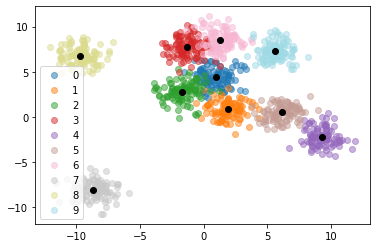

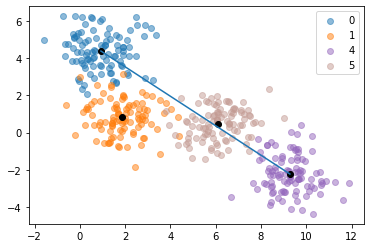

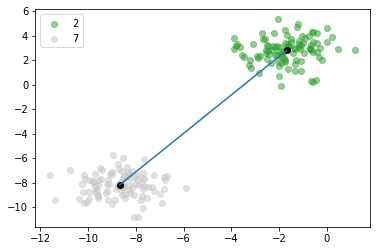

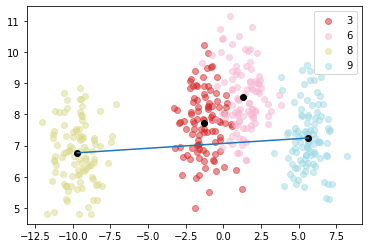

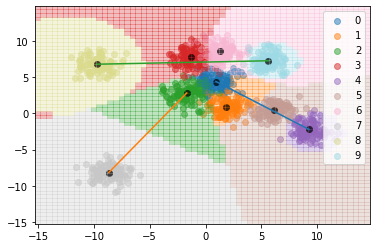

Correct in class 0: 71/100
Correct in class 1: 84/100
Correct in class 2: 90/100
Correct in class 3: 92/100
Correct in class 4: 97/100
Correct in class 5: 98/100
Correct in class 6: 87/100
Correct in class 7: 100/100
Correct in class 8: 100/100
Correct in class 9: 96/100


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

nan nan 1
nan nan


In [10]:
seeds=range(1)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=1000#np.array([10,20,30,40,50,60,70,80,90,100])*2
num_classes=10
num_lines=3
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct = regular_experiment(num_samples, num_classes, num_lines, seed, True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/1 [00:00<?, ?it/s]

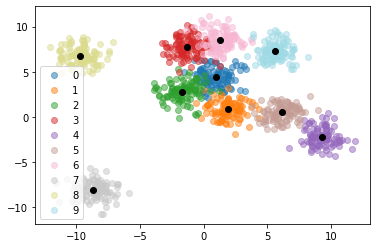

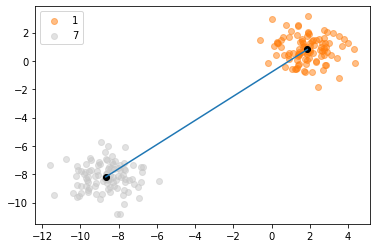

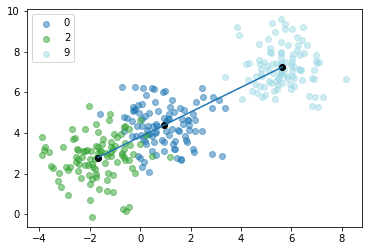

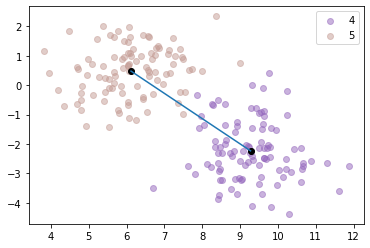

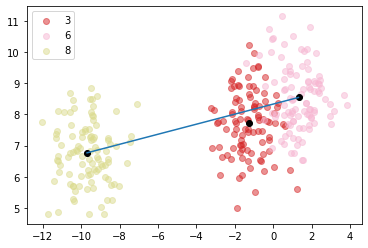

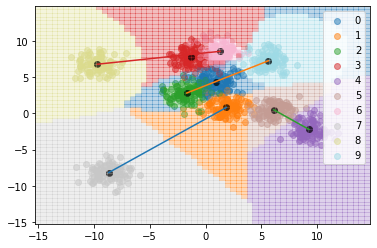

Correct in class 0: 97/100
Correct in class 1: 93/100
Correct in class 2: 84/100
Correct in class 3: 91/100
Correct in class 4: 99/100
Correct in class 5: 98/100
Correct in class 6: 70/100
Correct in class 7: 100/100
Correct in class 8: 100/100
Correct in class 9: 100/100


100%|██████████| 1/1 [00:22<00:00, 22.50s/it]

nan nan 1
nan nan


In [120]:
seeds=range(1)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=1000#np.array([10,20,30,40,50,60,70,80,90,100])*2
num_classes=10
num_lines=4
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct = regular_experiment(num_samples, num_classes, num_lines, seed, True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/1 [00:00<?, ?it/s]

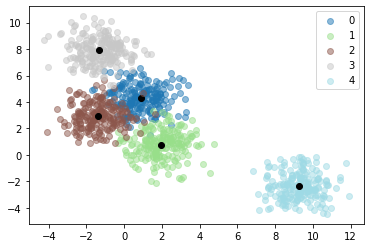

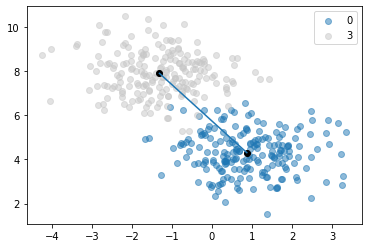

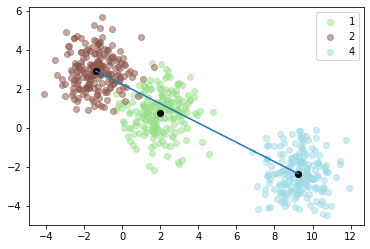

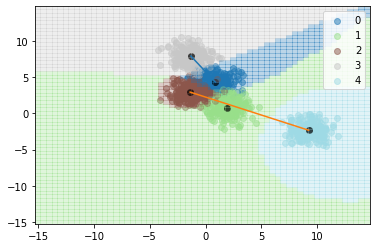

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Correct in class 0: 165/200
Correct in class 1: 196/200
Correct in class 2: 185/200
Correct in class 3: 197/200
Correct in class 4: 200/200
943.0 951.0 1
0.0 0.0
0.0 0.0


In [123]:
seeds=range(1)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=1000#np.array([10,20,30,40,50,60,70,80,90,100])*2
num_classes=5
num_lines=2
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct,_ = regular_experiment(num_samples, num_classes, num_lines, seed, True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))
print(np.std([tc/num_samples for tc in tc_list]), np.std([knnc/num_samples for knnc in knnc_list]))

  0%|          | 0/1 [00:00<?, ?it/s]

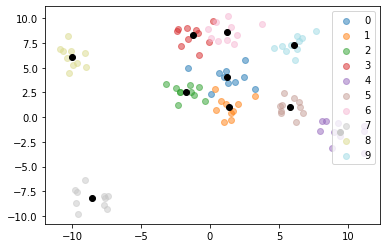

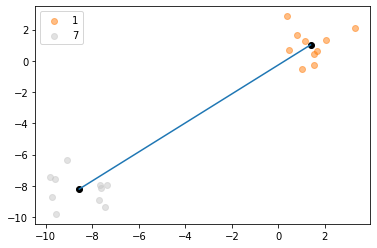

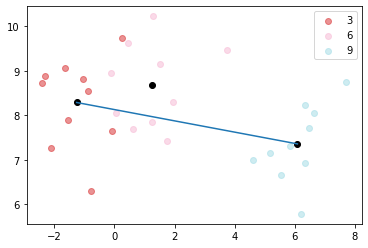

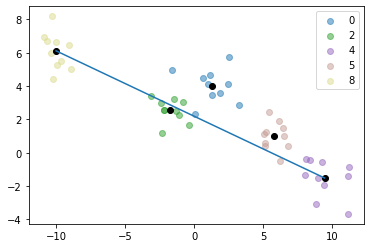

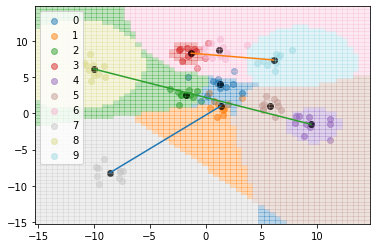

100%|██████████| 1/1 [00:04<00:00,  4.56s/it]

Correct in class 0: 8/10
Correct in class 1: 6/10
Correct in class 2: 9/10
Correct in class 3: 7/10
Correct in class 4: 9/10
Correct in class 5: 10/10
Correct in class 6: 10/10
Correct in class 7: 10/10
Correct in class 8: 10/10
Correct in class 9: 10/10
89.0 94.0 0
0.0 0.0


In [124]:
seeds=range(1)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=100#np.array([10,20,30,40,50,60,70,80,90,100])*2
num_classes=10
num_lines=3
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct,_ = regular_experiment(num_samples, num_classes, num_lines, seed, True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/1 [00:00<?, ?it/s]

(10, 20, 30, 40, 50, 60, 70, 80, 90, 100)


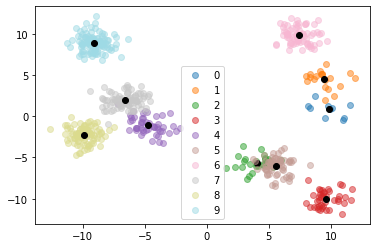

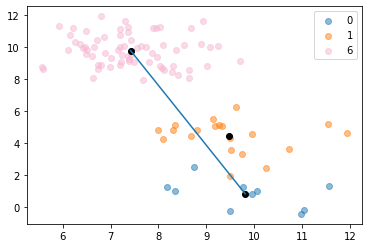

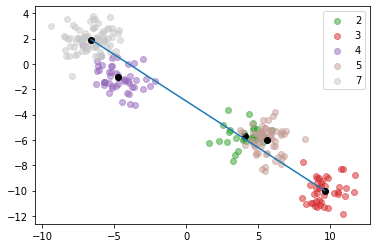

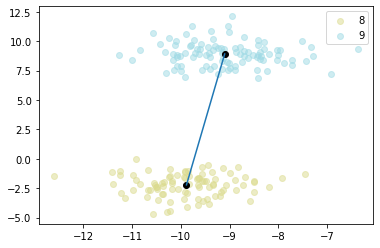

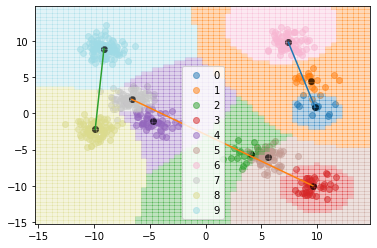

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

Correct in class 0: 9/10
Correct in class 1: 18/20
Correct in class 2: 25/30
Correct in class 3: 40/40
Correct in class 4: 48/50
Correct in class 5: 44/60
Correct in class 6: 70/70
Correct in class 7: 61/80
Correct in class 8: 90/90
Correct in class 9: 100/100
505.0 529.0 0
0.0 0.0


In [137]:
seeds=range(4,5)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=tuple(np.array([10,20,30,40,50,60,70,80,90,100]))
print(num_samples)
num_classes=None
num_lines=3
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct,_ = regular_experiment(num_samples, num_classes, num_lines, seed, True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/1 [00:00<?, ?it/s]

[ 10  10  10  10  10 100 100 100 100 100]


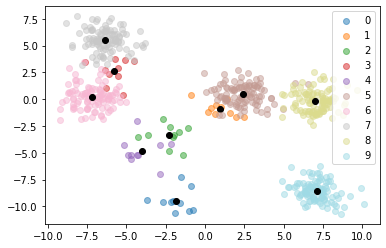

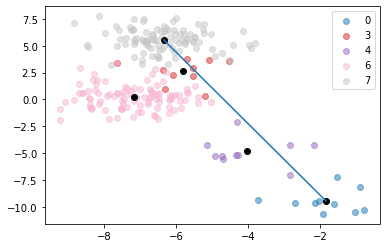

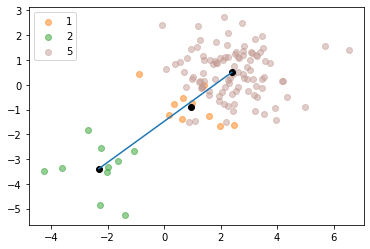

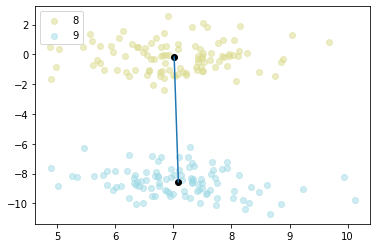

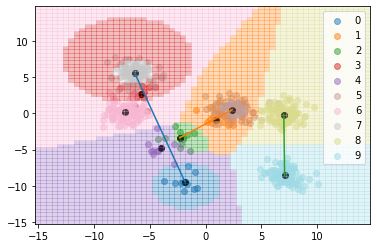

100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

Correct in class 0: 10/10
Correct in class 1: 10/10
Correct in class 2: 5/10
Correct in class 3: 8/10
Correct in class 4: 9/10
Correct in class 5: 52/100
Correct in class 6: 89/100
Correct in class 7: 71/100
Correct in class 8: 100/100
Correct in class 9: 100/100
454.0 501.0 0
0.0 0.0


In [134]:
seeds=range(2,3)
tc_list =[]
tp_list =[]
knnc_list=[]
fail_count=0
num_samples=np.array([10,10,10,10,10,100,100,100,100,100])
print(num_samples)
num_classes=None
num_lines=3
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct,_ = regular_experiment(num_samples, num_classes, num_lines, seed, True, brute=True)
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        #print("Correctly predicted: {0}/{1}".form\\at(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
print(np.mean(tc_list), np.mean(knnc_list), fail_count)
print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/1 [00:00<?, ?it/s]

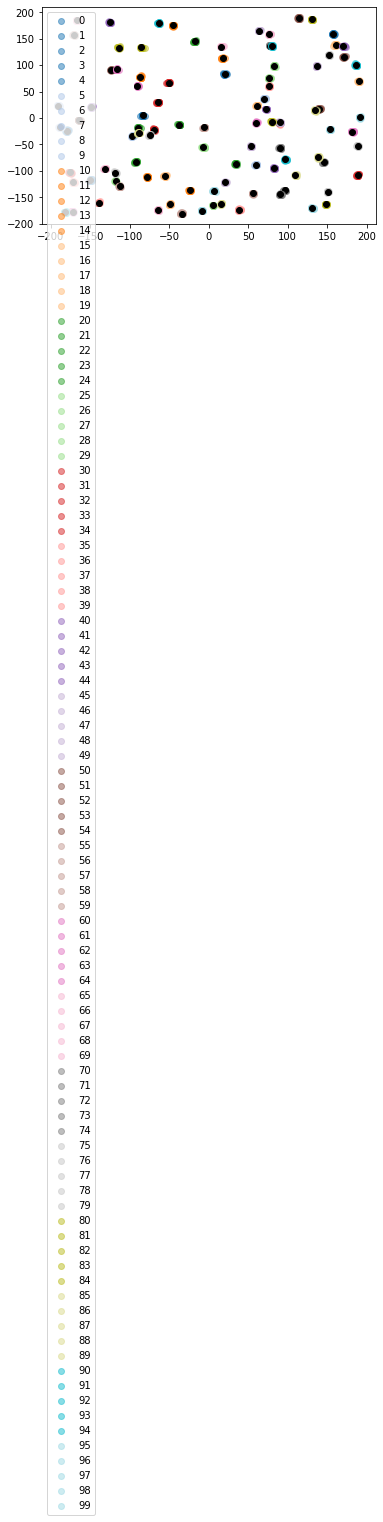

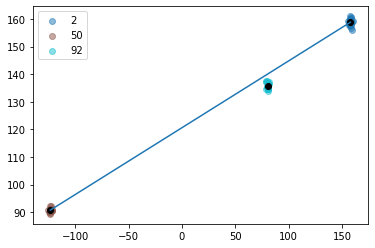

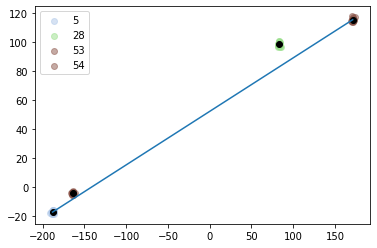

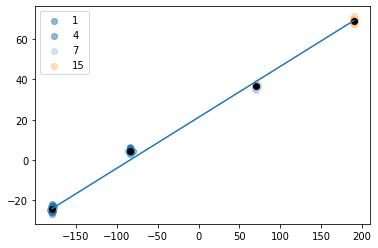

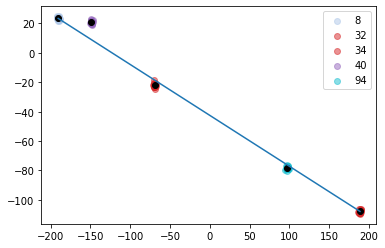

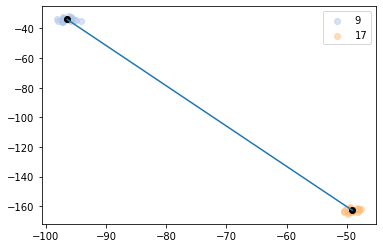

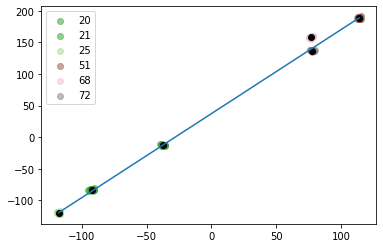

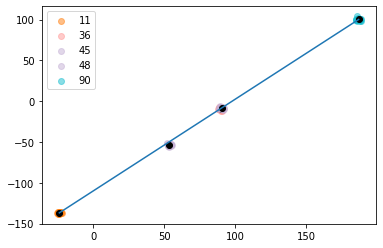

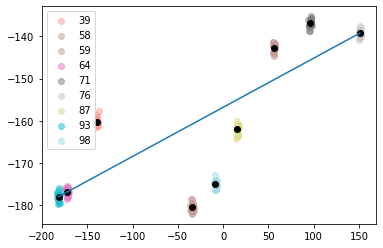

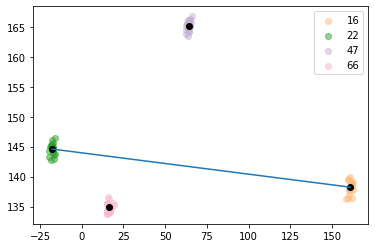

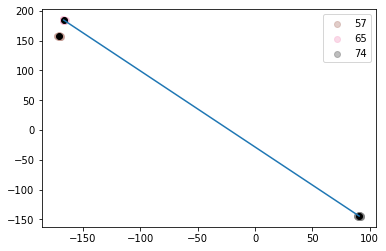

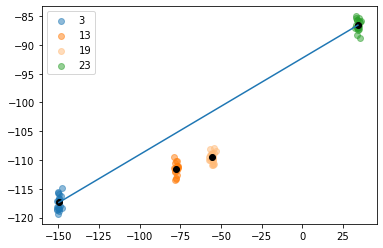

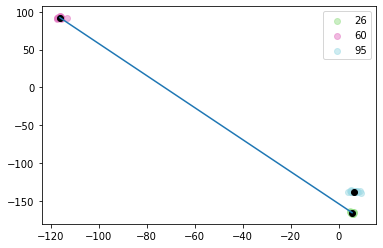

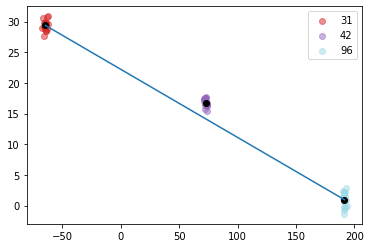

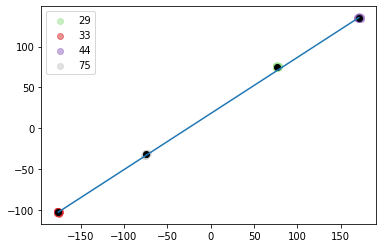

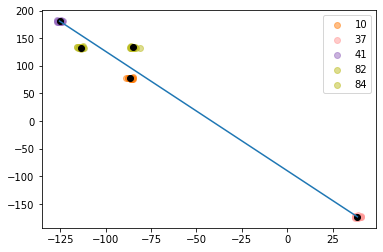

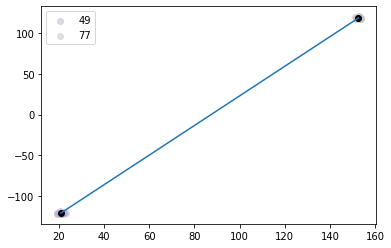

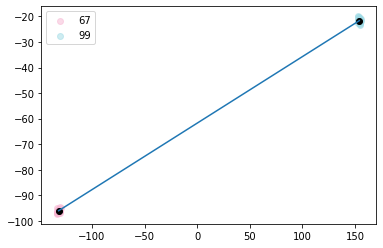

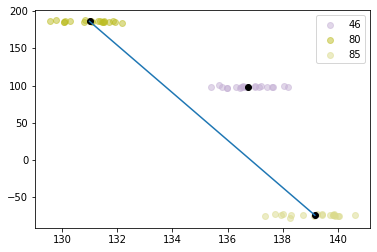

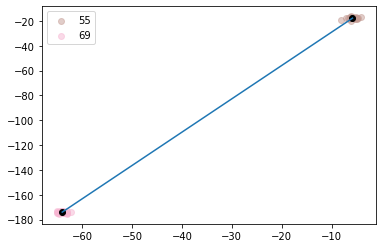

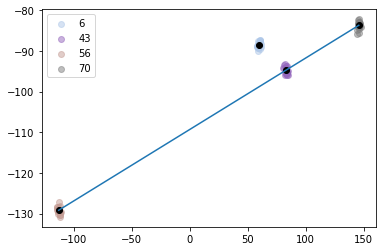

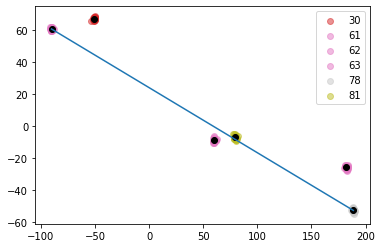

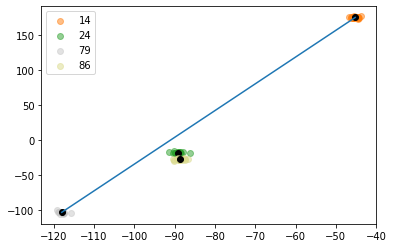

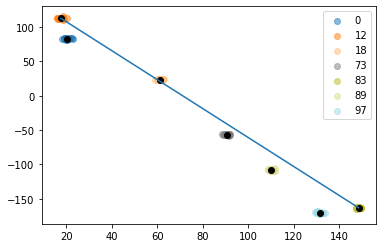

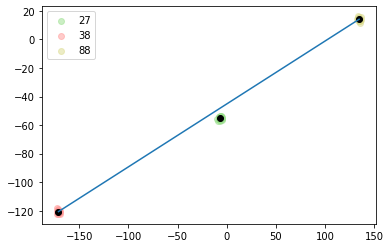

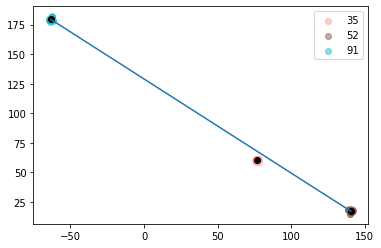

100%|██████████| 1/1 [07:26<00:00, 446.87s/it]


nan nan nan 1
nan nan


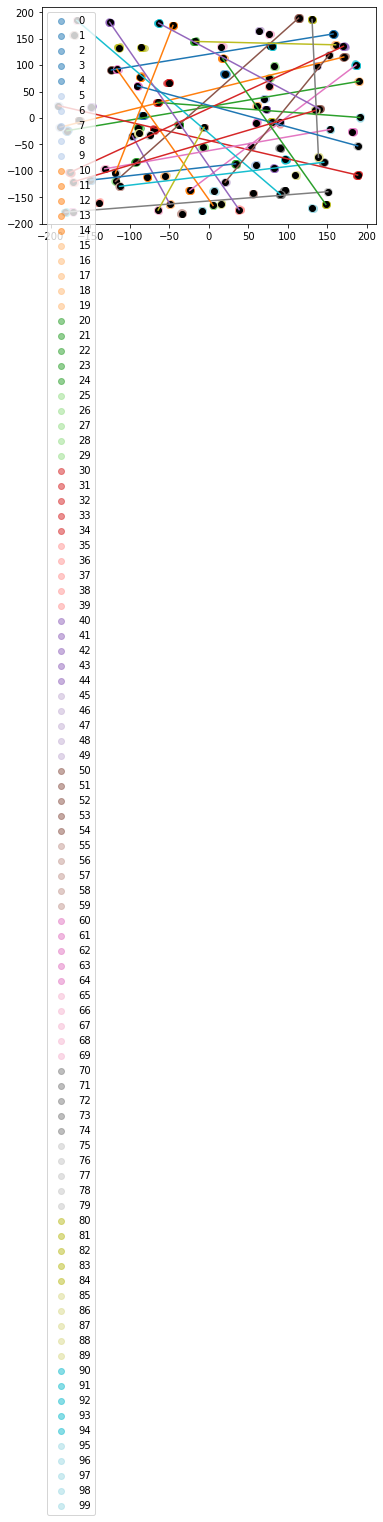

In [11]:
seeds=range(3,4)
tc_list =[]
tp_list =[]
knnc_list=[]
nline_list=[]
fail_count=0
num_samples=2000#np.array([10,20,30,40,50,60,70,80,90,100])*2
#points_surf = np.random.poisson(lam=7, size=(49,2))*20
#print(len(np.unique(points_surf, axis=1)))
num_classes=100
num_lines=50
for seed in tqdm(seeds):
    try:
        clist,plist,knn_correct, true_num_lines,_ = regular_experiment(num_samples, num_classes, num_lines, seed, True, brute=False, max_diff=100.01, center_box=(-200,200))
        total_points = sum(plist)
        total_correct = sum(clist)
        tp_list.append(total_points)
        tc_list.append(total_correct)
        knnc_list.append(knn_correct)
        nline_list.append(true_num_lines)
        #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
        #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
    except:
        fail_count+=1
    if len(tp_list)==100:
        break
print(np.mean(tc_list), np.mean(knnc_list), np.mean(nline_list), fail_count )
print(np.std(tc_list), np.std(knnc_list))

## Multi-dim Experiments

In [185]:
seeds=range(500)


num_samples=2000#np.array([10,20,30,40,50,60,70,80,90,100])*2
#points_surf = np.random.poisson(lam=7, size=(49,2))*20
#print(len(np.unique(points_surf, axis=1)))
num_classes=80
num_lines=80
#num_dims=2
for num_dims in range(2,11):
    fail_count=0
    tc_list =[]
    tp_list =[]
    knnc_list=[]
    nline_list=[]
    for seed in tqdm(seeds):
        try:
            clist,plist,knn_correct, true_num_lines = multiD_experiment(num_samples, num_classes, num_lines, seed, False, brute=False, max_diff=0.01, center_box=(-20,20), num_dims=num_dims)
            total_points = sum(plist)
            total_correct = sum(clist)
            tp_list.append(total_points)
            tc_list.append(total_correct)
            knnc_list.append(knn_correct)
            nline_list.append(true_num_lines)
            #print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
            #print("Vanilla kNN predicted: {0}/{1}".format(knn_correct,total_points))
        except:
            fail_count+=1
        if len(tp_list)==100:
            break
    print("Dimension: {0}".format(num_dims))
    print(np.mean(tc_list), np.mean(knnc_list), np.mean(nline_list), fail_count )
    print(np.std(tc_list), np.std(knnc_list))

  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 2
992.86 1564.4 23.31 6
67.70539417210419 41.390095433569606


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 3
1383.06 1947.66 22.68 2
92.6699325563583 19.061070274252703


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 4
1433.2 1994.14 22.56 39
109.52123081850385 4.259154845741112


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 5
1401.99 1999.24 21.97 61
123.09569407578805 1.68


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 6
1383.24 1999.97 22.27 110
136.71072525592132 0.2215851980616034


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 7
1339.78 2000.0 21.8 155
134.73474533319163 0.0


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 8
1305.96 2000.0 21.39 186
124.49537501449602 0.0


  0%|          | 0/500 [00:00<?, ?it/s]

Dimension: 9
1273.04 2000.0 21.53 228
147.05059809466945 0.0


 76%|███████▌  | 379/500 [11:56<03:48,  1.89s/it]

Dimension: 10
1260.0 2000.0 21.51 280
140.22332188334437 0.0


## Experiments with real data 
(Note: These can be quite unstable.)

In [29]:
leaf = pd.read_csv("100plants.csv")
np.unique(leaf[leaf.columns[-1]])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [111]:
def realdat_experiment(dname, num_lines, random_state,  visualize=False, brute=False, max_diff=1.1, center_box=(-10,10), num_dims=2):
    data = pd.read_csv(dname)
    print(data)
    dat=[np.array(data[data.columns[:-1]]),np.array(data[data.columns[-1]])-1]
    num_classes=len(np.unique(dat[1]))
    num_samples=len(dat[1])
    num_dims=dat[0].shape[1]
    #dat=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=random_state, center_box=center_box, n_features=num_dims)
#     print(dat[0].shape)
#     print(dat[1].shape)
    if num_classes is None:
        num_classes = len(num_samples)
    elif not isinstance(num_classes, int):
        num_classes = len(num_classes)
    centroids=[]
    cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # print(colors)
    for i in range(num_classes):
        temp=dat[0][dat[1]==i]
        xs=[[t[j] for t in temp] for j in range(num_dims)]
        
#         x=[t[0] for t in temp]
#         y=[t[1] for t in temp]
        centroid=np.array([np.mean(x) for x in xs])
        centroids.append(centroid)
        if visualize:
            plt.scatter(xs[0],xs[1], label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(xs[0]),np.mean(xs[1]),c="black")
#     print(dat[0].shape)
#     dat[0]=np.vstack([np.array(centroids),np.array(centroids)])
#     print(dat[0].shape)
    if visualize:
        plt.legend()
        plt.show()
    if brute:
        lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,num_lines)]
    else: 
        lines = [line_order_no_endpoints(centroids, np.array(line)) for line in find_lines_R_multiD(dat,centroids,dims=num_dims, k=num_lines, max_diff=max_diff)]
        
    if visualize:
        [vis_line(line, num_classes, dat, centroids, colors) for line in lines]
    clfs=[]
#     print(centroids)
    print(lines)
    for line in lines:
#         print(line)
#         print(centroids)
        distX,distY=get_line_prototypes(line, centroids)
        #print(distX)
        clf = SoftKNN(k=2)
        clf.fit(distX, distY)
        clfs.append(clf)
    clf_knn = SoftKNN(k=1)
    knn_labels=np.zeros((num_classes, num_classes))
    np.fill_diagonal(knn_labels,1)
    clf_knn.fit(centroids,knn_labels)
    if visualize:   
        for i in range(num_classes):
            temp=dat[0][dat[1]==i]
            x=[t[0] for t in temp]
            y=[t[1] for t in temp]
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
        for line in lines:
            plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])

        plt.legend()   
        x_min, x_max = center_box[0]-5, center_box[1]+5
        y_min, y_max = center_box[0]-5, center_box[1]+5
        h=0.5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
        line_assignments=[]
        for point in np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())]:
            dists = [dist_to_line_multiD(point, centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            line_assignments.append(nearest)
        ZS=[]
        for clf in clfs:
            Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())])
            ZS.append(Z1)
        Z=[ZS[line_assignments[i]][i] for i in range(len(line_assignments))]
        Z = np.array(Z).reshape(xx.shape)
    
        color_alpha=0.3
        plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=num_classes-1, shading='auto')
        plt.show()
    correct_list = []
    points_list = []
    for i in range(num_classes):
        points = np.sum([dat[1] == i])
        preds=[]
        for clf in clfs:
            preds1=clf.predict(dat[0][dat[1] == i])
            preds.append(preds1)
        assignments=[]
        for point in dat[0][dat[1] == i]:
            dists = [dist_to_line_multiD(point,centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            assignments.append(nearest)
        preds=[preds[assignments[i]][i] for i in range(len(assignments))]
        correct = np.sum(preds==dat[1][dat[1] == i])
        correct_list.append(correct)
        points_list.append(points)
        if visualize:
            print("Correct in class {2}: {0}/{1}".format(correct,points,i))
    knn_preds=clf_knn.predict(dat[0])
    knn_correct=np.sum(knn_preds==dat[1])
    return correct_list, points_list, knn_correct, len(lines)


clist,plist,knnc,nlines=realdat_experiment("penguins.csv", 2, 0,  visualize=False, brute=False, max_diff=1.1, center_box=(-10,10))
print (sum(clist)/sum(plist), knnc/sum(plist))

     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  label
0              39.1           18.7              181.0       3750.0      3
1              39.5           17.4              186.0       3800.0      3
2              40.3           18.0              195.0       3250.0      3
3              36.7           19.3              193.0       3450.0      3
4              39.3           20.6              190.0       3650.0      3
..              ...            ...                ...          ...    ...
337            55.8           19.8              207.0       4000.0      4
338            43.5           18.1              202.0       3400.0      4
339            49.6           18.2              193.0       3775.0      4
340            50.8           19.0              210.0       4100.0      4
341            50.2           18.7              198.0       3775.0      4

[342 rows x 5 columns]
[array([4, 3, 2, 1, 0])]
0.4327485380116959 0.5029239766081871


In [119]:
def realdat_experiment(dname, num_lines, random_state,  visualize=False, brute=False, max_diff=1.1, center_box=(-10,10), num_dims=2):
    data = pd.read_csv(dname)
    print(data)
    dat=[np.array(data[data.columns[:-1]]),np.array(data[data.columns[-1]])-1]
    num_classes=len(np.unique(dat[1]))
    num_samples=len(dat[1])
    num_dims=dat[0].shape[1]
    #dat=datasets.make_blobs(n_samples=num_samples, centers=num_classes, random_state=random_state, center_box=center_box, n_features=num_dims)
#     print(dat[0].shape)
#     print(dat[1].shape)
    if num_classes is None:
        num_classes = len(num_samples)
    elif not isinstance(num_classes, int):
        num_classes = len(num_classes)
    centroids=[]
    cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # print(colors)
    for i in range(num_classes):
        temp=dat[0][dat[1]==i]
        xs=[[t[j] for t in temp] for j in range(num_dims)]
        
#         x=[t[0] for t in temp]
#         y=[t[1] for t in temp]
        centroid=np.array([np.mean(x) for x in xs])
        centroids.append(centroid)
        if visualize:
            plt.scatter(xs[0],xs[1], label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(xs[0]),np.mean(xs[1]),c="black")
#     print(dat[0].shape)
#     dat[0]=np.vstack([np.array(centroids),np.array(centroids)])
#     print(dat[0].shape)
    if visualize:
        plt.legend()
        plt.show()
    if brute:
        lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,num_lines)]
    else: 
        lines = [line_order_no_endpoints(centroids, np.array(line)) for line in find_lines_R_multiD(dat,centroids,dims=num_dims, k=num_lines, max_diff=max_diff)]
        
    if visualize:
        [vis_line(line, num_classes, dat, centroids, colors) for line in lines]
    clfs=[]
#     print(centroids)
    print(lines)
    for line in lines:
#         print(line)
#         print(centroids)
        distX,distY=get_line_prototypes(line, centroids)
        #print(distX)
        clf = SoftKNN(k=2)
        clf.fit(distX, distY)
        clfs.append(clf)
    clf_knn = SoftKNN(k=1)
    knn_labels=np.zeros((num_classes, num_classes))
    np.fill_diagonal(knn_labels,1)
    clf_knn.fit(centroids,knn_labels)
    if visualize:   
        for i in range(num_classes):
            temp=dat[0][dat[1]==i]
            x=[t[0] for t in temp]
            y=[t[1] for t in temp]
            plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
            plt.scatter(np.mean(x),np.mean(y),c="black")
        for line in lines:
            plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])

        plt.legend()   
        x_min, x_max = center_box[0]-5, center_box[1]+5
        y_min, y_max = center_box[0]-5, center_box[1]+5
        h=0.5

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
        line_assignments=[]
        for point in np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())]:
            dists = [dist_to_line_multiD(point, centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            line_assignments.append(nearest)
        ZS=[]
        for clf in clfs:
            Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel(),[0]*len(xx.ravel())])
            ZS.append(Z1)
        Z=[ZS[line_assignments[i]][i] for i in range(len(line_assignments))]
        Z = np.array(Z).reshape(xx.shape)
    
        color_alpha=0.3
        plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=num_classes-1, shading='auto')
        plt.show()
    correct_list = []
    points_list = []
    for i in range(num_classes):
        points = np.sum([dat[1] == i])
        preds=[]
        for clf in clfs:
            preds1=clf.predict(dat[0][dat[1] == i])
            preds.append(preds1)
        assignments=[]
        for point in dat[0][dat[1] == i]:
            dists = [dist_to_line_multiD(point,centroids[line[0]],centroids[line[-1]]) for line in lines]    
            nearest=np.argmin(dists)
            assignments.append(nearest)
        preds=[preds[assignments[i]][i] for i in range(len(assignments))]
        correct = np.sum(preds==dat[1][dat[1] == i])
        correct_list.append(correct)
        points_list.append(points)
        if visualize:
            print("Correct in class {2}: {0}/{1}".format(correct,points,i))
    knn_preds=clf_knn.predict(dat[0])
    knn_correct=np.sum(knn_preds==dat[1])
    return correct_list, points_list, knn_correct, len(lines)


clist,plist,knnc,nlines=realdat_experiment("ecoli.csv", 3, 0,  visualize=False, brute=False, max_diff=0.1, center_box=(-10,10))
print (sum(clist)/sum(plist), knnc/sum(plist))

      mcg   gvh   lip   aac  alm1  alm2  label
0    0.49  0.29  0.48  0.56  0.24  0.35      1
1    0.07  0.40  0.48  0.54  0.35  0.44      1
2    0.56  0.40  0.48  0.49  0.37  0.46      1
3    0.59  0.49  0.48  0.52  0.45  0.36      1
4    0.23  0.32  0.48  0.55  0.25  0.35      1
..    ...   ...   ...   ...   ...   ...    ...
322  0.74  0.56  0.48  0.47  0.68  0.30      5
323  0.71  0.57  0.48  0.48  0.35  0.32      5
324  0.61  0.60  0.48  0.44  0.39  0.38      5
325  0.59  0.61  0.48  0.42  0.42  0.37      5
326  0.74  0.74  0.48  0.31  0.53  0.52      5

[327 rows x 7 columns]
[array([2, 1]), array([3, 4, 0])]
0.8134556574923547 0.8654434250764526


In [115]:
data=pd.read_csv("ecoli.csv")
data['label']=0
for i in range(len(np.unique(data['class']))):
    indices= data['class']==(np.unique(data['class'])[i])
    data['label'][indices]=i+1
data=data[data.columns[[0,1,2,4,5,6,-1]]].dropna()
pd.DataFrame.to_csv(data,"ecoli.csv", index=False)

In [77]:
from palmerpenguins import load_penguins

data=load_penguins()
data['label_str']=data['species']+data['island']
data['label']=0
for i in range(len(np.unique(data['label_str']))):
    indices= data['label_str']==(np.unique(data['label_str'])[i])
    data['label'][indices]=i+1
data=data[data.columns[[2,3,4,5,-1]]].dropna()
pd.DataFrame.to_csv(data,"penguins.csv", index=False)

## Random snippets of code
Some of these may be helpful for understanding how the different components of the experiments works

100%|██████████| 14190/14190 [00:02<00:00, 5317.69it/s]
/home/ilia10000/Workspace/SLkNN/protos/lib/python3.7/site-packages/ipykernel_launcher.py:241: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


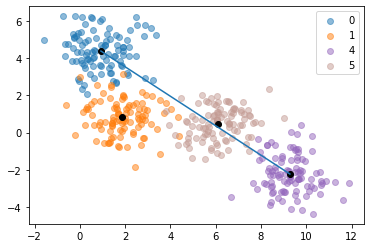

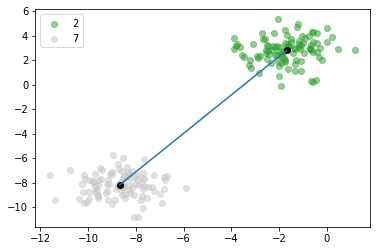

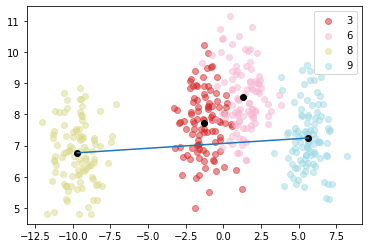

[None, None, None]

In [795]:
lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,3)]
[vis_line(line, num_classes, dat, centroids) for line in lines]

In [666]:
x = np.array([1, 2, 3])
y=np.array([5,6])
np.subtract.outer(y,x)

array([[4, 3, 2],
       [5, 4, 3]])

In [650]:
lines=list(combinations(range(num_classes),2))
lines=np.array(lines)
triple_lines=np.array(list(combinations(range(len(lines)),3)))
index_lines=np.array(lines[triple_lines])
index_centroids=np.array(centroids)[index_lines]

In [586]:
line_order(centroids, np.array([8,9,3,6]))

[0.0, 15.343430542749461, 8.444424972681357, 11.059929777197704]


array([8, 3, 6, 9])

## Dataset creation and visualization

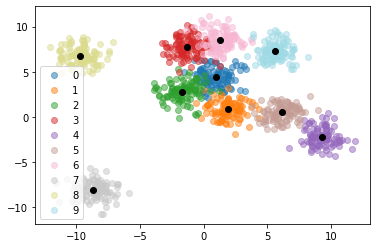

In [165]:
num_classes = 10
dat=datasets.make_blobs(n_samples=1000, centers=num_classes, random_state=0)
centroids=[]
cmap="tab20"
cmap_single = get_cmap(num_classes, cmap)
colors=cmap_single(range(num_classes))
# print(colors)
for i in range(num_classes):
    temp=dat[0][dat[1]==i]
    x=[t[0] for t in temp]
    y=[t[1] for t in temp]
    centroid=np.array([np.mean(x),np.mean(y)])
    centroids.append(centroid)
    plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
    plt.scatter(np.mean(x),np.mean(y),c="black")
plt.legend()
plt.show()

## Visualizing a single line and getting features

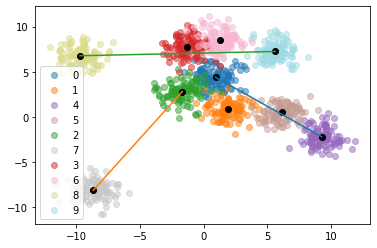

In [169]:
lines=[line_order(centroids, np.array(line)) for line in find_lines_brute(centroids,3)]
[vis_line(line, num_classes, dat, centroids, colors, return_plt=True) for line in lines]
plt.show()

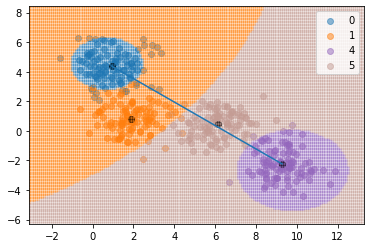

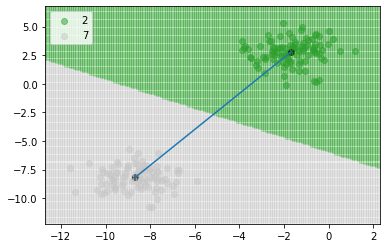

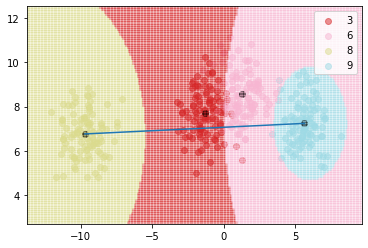

In [179]:
clfs=[]
for line in lines:
    distX,distY=get_line_prototypes(line, centroids)
    clf = SoftKNN(k=2)
    clf.fit(distX, distY)
    clfs.append(clf)
for i in range(len(lines)):
    line=lines[i]
    clf=clfs[i]
    plt=vis_line(line, num_classes,dat, centroids, colors, return_plt=True)
    x_min, x_max = np.min(np.array(centroids)[line][:,0])-4, np.max(np.array(centroids)[line][:,0])+4
    y_min, y_max = np.min(np.array(centroids)[line][:,1])-4, np.max(np.array(centroids)[line][:,1])+4
    h=0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #     return
    color_alpha=0.3
    plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=9, shading='auto')
    plt.show()

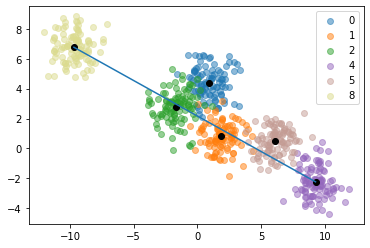

In [436]:
line1 = np.array([8,2,0,1,5,4])
vis_line(line1, num_classes, dat, centroids)
n=len(line1)


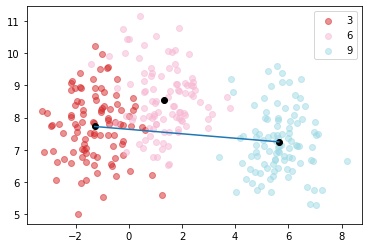

In [451]:
line2 = np.array([3,6,9])
vis_line(line2, num_classes, dat, centroids)
n=len(line2)

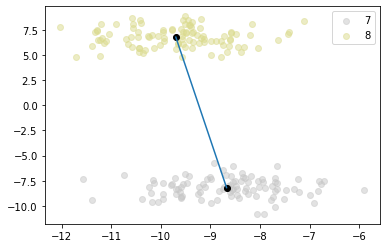

In [465]:
line3 = np.array([8,7])
vis_line(line3, num_classes, dat, centroids)
n=len(line3)

## Creating prototypes and fitting the model

In [797]:
clfs=[]
for line in lines:
    distX,distY=get_line_prototypes(line, centroids)
    clf = SoftKNN(k=2)
    clf.fit(distX, distY)
    clfs.append(clf)

In [462]:
distX,distY=get_line_prototypes(line1, centroids)
#x.value[0:n]
#[0.43055920069980025, 0.4254206058810914, 0.11332761963968979, 0.030692574098209746, -3.194571232751557e-10]
#[ 0.01+4.46497381e-01,  0.01+4.39457867e-01,  9.49660354e-02,  0.01+1.90787168e-02,-1.25290335e-10]
#labels_2_points_n_classes(5)#active_classes
#distY[1,active_classes]=x.value[n:]
#[-3.972110480480517e-10, 0.01898678224225448, 0.3038746550705993, 0.33694678987309357, 0.3401917732115191]
#[-1.34947027e-10,  0.01+9.48279153e-03,  3.13923395e-01,  3.38292367e-01,0.005+3.38301447e-01]#labels_2_points_n_classes(5)[::-1]#active_classes[::-1]
# print(distY)

clf = SoftKNN(k=2)
clf.fit(distX, distY)


In [453]:
distX,distY=get_line_prototypes(line2, centroids)
clf2 = SoftKNN(k=2)
clf2.fit(distX, distY)


In [466]:
distX,distY=get_line_prototypes(line3, centroids)
clf3 = SoftKNN(k=2)
clf3.fit(distX, distY)


## Visualizing prototype-based classification

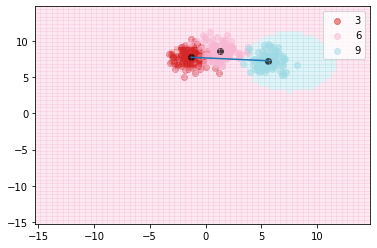

In [454]:
# print(colors)
plt=vis_line(line2, num_classes,dat, centroids, return_plt=True)
x_min, x_max = -15, 15
y_min, y_max = -15, 15
h=0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
#     return
color_alpha=0.3
plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=9, shading='auto')
plt.show()

## Calculating accuracy

In [456]:
total_points = sum(np.any([dat[1] == i for i in line2], axis=0))
total_correct = np.sum(clf2.predict(dat[0][np.any([dat[1] == i for i in line2], axis=0)])==dat[1][np.any([dat[1] == i for i in line2], axis=0)])
print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
for i in line2:
    points = np.sum([dat[1] == i])
    correct = np.sum(clf2.predict(dat[0][dat[1] == i])==dat[1][dat[1] == i])
    print("Correct in class {2}: {0}/{1}".format(correct,points,i))


Correctly predicted: 269/300
Correct in class 3: 74/100
Correct in class 6: 97/100
Correct in class 9: 98/100


## Assign each point to a line

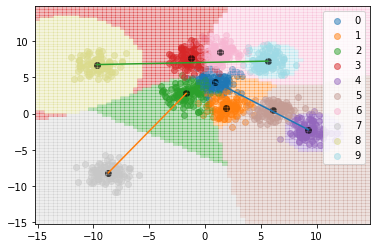

Correct in class 0: 71/100
Correct in class 1: 84/100
Correct in class 2: 90/100
Correct in class 3: 92/100
Correct in class 4: 97/100
Correct in class 5: 98/100
Correct in class 6: 87/100
Correct in class 7: 100/100
Correct in class 8: 100/100
Correct in class 9: 96/100


In [183]:
# print(colors)
# lines=[line1,line2,line3]
# clfs=[clf,clf2, clf3]

for i in range(num_classes):
    temp=dat[0][dat[1]==i]
    x=[t[0] for t in temp]
    y=[t[1] for t in temp]
    if True:
        plt.scatter(x,y, label=i, color=colors[i], alpha=0.5)
        plt.scatter(np.mean(x),np.mean(y),c="black")
for line in lines:
    plt.plot([centroids[line[0]][0],centroids[line[-1]][0]],[centroids[line[0]][1],centroids[line[-1]][1]])

plt.legend()
x_min, x_max = -15, 15
y_min, y_max = -15, 15
h=0.4

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
line_assignments=[]
for point in np.c_[xx.ravel(), yy.ravel()]:
#     dists = [get_dist_to_line(point, line, centroids) for line in lines]
    dists = [dist_to_line(*centroids[line[0]],*centroids[line[-1]], *point) for line in lines]    
    nearest=np.argmin(dists)
    line_assignments.append(nearest)
ZS=[]
for clf in clfs:
    Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZS.append(Z1)
# Z1 = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Z2 = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
# Z3 = clf3.predict(np.c_[xx.ravel(), yy.ravel()])
# ZS=[Z1,Z2,Z3]
Z=[ZS[line_assignments[i]][i] for i in range(len(line_assignments))]
#Z = [clfs[line_assignments[i]].predict(list(np.c_[xx.ravel(), yy.ravel()][i])) for i in range(len(line_assignments))]
Z = np.array(Z).reshape(xx.shape)
#     return
color_alpha=0.3
plt.pcolormesh(xx, yy, Z, cmap=cmap_single, alpha=color_alpha, vmin=0, vmax=num_classes-1, shading='auto')
plt.show()
# total_points = sum(np.any([dat[1] == i for i in active_classes], axis=0))
# total_correct = np.sum(clf.predict(dat[0][np.any([dat[1] == i for i in active_classes], axis=0)])==dat[1][np.any([dat[1] == i for i in active_classes], axis=0)])
# print("Correctly predicted: {0}/{1}".format(total_correct,total_points))
for i in range(num_classes):
    points = np.sum([dat[1] == i])
    preds=[]
    for clf in clfs:
        preds1=clf.predict(dat[0][dat[1] == i])
        preds.append(preds1)
#     preds1=clf.predict(dat[0][dat[1] == i])
#     preds2=clf2.predict(dat[0][dat[1] == i])
#     preds3=clf3.predict(dat[0][dat[1] == i])
    assignments=[]
    for point in dat[0][dat[1] == i]:
    #     dists = [get_dist_to_line(point, line, centroids) for line in lines]
        dists = [dist_to_line(*centroids[line[0]],*centroids[line[-1]], *point) for line in lines]    
        nearest=np.argmin(dists)
        assignments.append(nearest)
#     preds=[preds1,preds2, preds3]
    preds=[preds[assignments[i]][i] for i in range(len(assignments))]
    correct = np.sum(preds==dat[1][dat[1] == i])
    print("Correct in class {2}: {0}/{1}".format(correct,points,i))


In [15]:
def labels_2_points_n_classes(n):
    denom = sum([j**2 for j in range(1,n)])
    y=[(n*(n-1)-i*(i-1))/denom for i in range(1,n+1)]
    y=[elem/sum(y) for elem in y]
    return y
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(1./(j/2.))
            vector[n-i+1-1]+=(1/(n-(j/2.)))
            vector[j-i+1-1]+=(-1./(j/2.))
            vector[n-j+i-1]+=(-1/(n-(j/2.)))
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def create_system_V2(n, mid_dists=None, tot_dist= None, endpoints=None):
    A=[]
    assert(len(mid_dists)==n-1)
    for i in range(len(mid_dists)):
        vector = np.zeros(n)
        vector[i] += 1./(mid_dists[i]-endpoints[0])
        vector[n-i-1] += 1./(endpoints[1]-mid_dists[i])
        
        vector[i+1] += -1./(mid_dists[i]-endpoints[0])
        vector[n-i-1-1] += -1./(endpoints[1]-mid_dists[i])
        A.append(vector)
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def create_system_V3(n, mid_dists=None, tot_dist= None, endpoints=None):
    A=[]
    assert(len(mid_dists)==n-1)
    for i in range(len(mid_dists)):
        vector = np.zeros(n*2)
        vector[i] += 1./(mid_dists[i]-endpoints[0])
        vector[n+i] += 1./(endpoints[1]-mid_dists[i])
        
        vector[i+1] += -1./(mid_dists[i]-endpoints[0])
        vector[n+i+1] += -1./(endpoints[1]-mid_dists[i])
        A.append(vector)
    #A.append(np.append(np.ones(n),np.zeros(n)))
    #A.append(np.append(np.zeros(n),np.ones(n)))
    #A.append(np.zeros(n*2))
    #A[-1][n-1]=1
    #A.append(np.zeros(n*2))
    #A[-1][2*n-1]=1
    b = np.zeros(len(A))
    #b[-4]=1
    #b[-3]=1
    return A, b
def solve_system(A,b):
    soln, _, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln

In [4]:
s=create_system(5)
s2 = create_system_V2(5, [0.5,1.5,2.5,3.5], 3, [0,5])
print(solve_system(*s))
print(list(solve_system(*s2)))
print(labels_2_points_n_classes(4))

[ 3.33333333e-01  3.00000000e-01  2.33333333e-01  1.33333333e-01
 -3.60822483e-16]
[0.3267831850497104, 0.3103848956972538, 0.23767549951183292, 0.11855585044210057, 0.005500474415918374]
[0.42857142857142855, 0.35714285714285715, 0.21428571428571427, 0.0]


In [97]:
np.linalg.lstsq(*s2,rcond=None)

(array([0.25, 0.25, 0.25, 0.25]),
 array([], dtype=float64),
 2,
 array([4.07921561e+00, 2.00000000e+00, 2.05299402e-16, 3.76660990e-17]))

In [48]:


s3=create_system_V2(len(active_classes), mid_dists=mid_dists, tot_dist= None, endpoints=[0,1+dists[-1]])
solve_system(*s3)

array([3.00604553e-01, 2.63104311e-01, 2.37716703e-01, 1.98482735e-01,
       7.64145821e-05])

In [16]:
s3=create_system_V3(len(active_classes), mid_dists=mid_dists, tot_dist= None, endpoints=[0,1+dists[-1]])
solve_system(*s3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
s3

([array([ 0.22355932, -0.22355932,  0.        ,  0.        ,  0.        ,
          0.05705233, -0.05705233,  0.        ,  0.        ,  0.        ]),
  array([ 0.        ,  0.09108344, -0.09108344,  0.        ,  0.        ,
          0.        ,  0.09072837, -0.09072837,  0.        ,  0.        ]),
  array([ 0.        ,  0.        ,  0.06667439, -0.06667439,  0.        ,
          0.        ,  0.        ,  0.14280425, -0.14280425,  0.        ]),
  array([ 0.        ,  0.        ,  0.        ,  0.05265145, -0.05265145,
          0.        ,  0.        ,  0.        ,  0.33244418, -0.33244418])],
 array([0., 0., 0., 0.]))

In [297]:
result

-inf

In [191]:
A@x.value

array([-13.93575431,  -0.09639336,  -0.10842547,  -0.13622866,
       -32.0092398 ])

In [186]:
print(list(x.value[0:5]))
print(list(x.value[5:10]))

[0.43055920069980025, 0.4254206058810914, 0.11332761963968979, 0.030692574098209746, -3.194571232751557e-10]
[-3.972110480480517e-10, 0.01898678224225448, 0.3038746550705993, 0.33694678987309357, 0.3401917732115191]


In [862]:
dat_temp=datasets.make_blobs(n_samples=1000, centers=16, random_state=0)
x=np.array(dat_temp[0][:,0])
y=np.array(dat_temp[0][:,1])
labels = dat_temp[1]
a=pd.DataFrame(np.array([x,y,labels]).transpose())
a.columns=[["X", "Y", "My Hopes And Dreams"]]
a.to_csv("blobs.csv", index=False)


In [12]:
from platform import python_version

print(python_version())

3.7.3
